In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
from scipy.special import logsumexp

# 1.Construction of the batch treatment model

## 1.1 Function and principles applied by the model


The Freundlich adsorption model represents the multilayer adsorption of an adsorbent on a solid surface and is represented by the function (1).



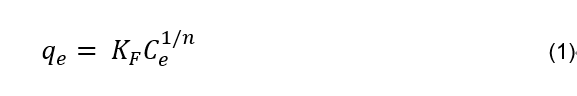

Ce is the concentration of As(III) in solution at equilibrium,qe is the concentration of As(III) in the adsorbent when the reaction reaches equilibrium and KF is the Freundlich constant, and n is experimentally determined constants


Combining predictive models of adsorption isotherms and adsorption kinetics to form an improved pseudo-second-order model for predictive modelling (shown in Function (2)). Furthermore, comparing the two modelling methods of batch and continuous treatment, the best solution, and suitable adsorbent concentration is found. 

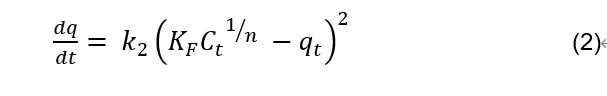

qe is the concentration of As(III) in the adsorbent when the reaction reaches equilibrium, qt is the quantity of arsenic adsorbed at time t,Ct is the concentration of aqueous As(III) at time t and k2 is the pseudo-second-order rate constant. 


Function (3) shows the equation for the reactor design model for batch treatment.

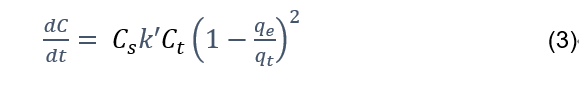

Where k’ is the rate constant,  Cs is sorbent concentrations


## 1.2 ODE Function



Differential equations are equations containing unknown functions and their derivatives. ODEs are Ordinary Differential Equations (ODEs) with only one independent variable

scipy.integrate.odeint() is a specific method for solving differential equations, solving systems of ordinary differential equations by numerical integration

In [ ]:
def DiffEq(conditions,t):
  
  time=t;

  j = exp[0][2];                # the reactor turnover rate 
  Cinfluent = exp[0][3];            # the inflow As(III) concentration 
  k = exp[0][4];                # rate constant
  Cs1 = exp[0][5];               # sorbent concentrations
  KF = exp[0][6];               # Freundlich constant
  n = exp[0][7];                # experimentally determined constants
  Qmax = exp[0][8];
  KL = exp[0][9];               
  isotherm=exp[0][10]
  
  order=exp[0][11] 

  Ct = conditions[0]              # concentration of aqueous As(III) at time t 
  qt[i] = conditions[1]             # the quantity of arsenic adsorbed at time t 
  Ct_mgL = Ct/1000
  qt_mgg = qt[i]/(Cs1*1000)

  if isotherm==1:
    # Freundlich
    rate_ads = 1000*k*Ct_mgL*Cs1*((1-(qt_mgg/(KF*(Ct_mgL**(1/n)))))**order)  # batch treatment reactor design
 
  elif isotherm==2:
    # Langmuir
    rate_ads= 1000*k*Ct_mgL*Cs1*((1-(qt_mgg/((Qmax*KL*Ct_mgL)/(1+KL*Ct_mgL))))**order) 


  if Ct <0.000001:
   Ct = 0.00001;   
   rate_ads=0;

  rate_influx = j*Cinfluent; 
  rate_outflux = j*Ct;
  dCdt = [-rate_ads+rate_influx-rate_outflux,rate_ads]         #batch treatment reactor design (when j=0)


  qt[i]=qt[i]+rate_ads
 
  

  return dCdt

## 1.3 Main model

In [ ]:
def Result_Processing (C_in,Cs0,days,ord_in=2,isotherms="Freundlich",k_in=0.1111,KF_in=5.10,n_in=2.63,Qmax_in=29.44,KL_in=0.11):
  
  global i
  global exp
  global qt
  qt=[0,0,0,0,0,0,0]
  number_of_experiments=7;
  number_of_variables = 12;
  results_table=[([0]*number_of_experiments) for i in range (10)]
  if isotherms=="Freundlich":
    isoth_in=1
  elif isotherms=="Langmuir":
    isoth_in=2

  for day in range(1,days+1):
    C_init = C_in;           # sorbent concentrations (initial value) 
    q_init = qt;           # the quantity of arsenic adsorbed at time t (initial value)     
    Cs = Cs0;            # sorbent concentrations  
    Cinfluent = 0;          # the inflow As(III) concentration 
    j = 0;              # the reactor turnover rate 
    k = k_in;            # rate constant

    KF = KF_in;            # Freundlich constant
    Qmax = Qmax_in
    isotherm=isoth_in
    order=ord_in
    KL=KL_in
    n = n_in;            # experimentally determined constants

    data_collect = [0,1,2,3,4,5,6,8,9,10,20,30,40,50,60,70,80,90,100,110,200,210,220,230,240,270,300,330,360,390,420,450,480,500,570,
                600,660,690,720,750,780,840,870,900,930,960,990,1000,1050,1080,1110,1140,
                1170,1200,1260,1290,1320,1350,1380,1410,1440]
    t_end = 1440
    
    t_steps = len(data_collect)
    t_step = t_end/t_steps;
    tt=list(np.arange(0,t_end+1,t_step))

  
    
    results_Ct=np.zeros((number_of_experiments,len(data_collect)))
    results_qt=np.zeros((number_of_experiments,len(data_collect)))
 
    experiments = [[0]*number_of_variables for _ in range(number_of_experiments)]
    Cs_col=[0]*number_of_experiments     
    for i in range(number_of_experiments) :
          experiments[i][0] = C_init;
          experiments[i][1] = q_init[i];
          experiments[i][2] = j;
          experiments[i][3] = Cinfluent;
          experiments[i][4] = k;
          experiments[i][5] = Cs*10**(i-4); #exponentially increasing sorbent concentration
          experiments[i][6] = KF;
          experiments[i][7] = n
          experiments[i][8] = Qmax
          experiments[i][9] = KL  
          experiments[i][10] = isotherm
          experiments[i][11] = order
          Cs_col[i]= experiments[i][5]  
 
    for i in range(number_of_experiments):
      
          exp = [[0]*number_of_variables for _ in range(1)]
          exp[0][:] = experiments[i][:]
          exp_C_init = exp[0][0]
          exp_q_init = exp[0][1]

          result = odeint(DiffEq,[exp_C_init,exp_q_init],data_collect,rtol=1e-6)
    

          results_Ct[i,:] = result[:,0]
        
          for j in range(len(results_Ct[i,:])):
            if results_Ct[i,:][j]<=10 and data_collect[j] ==1:
              results_table[0][i]+=1

            if results_Ct[i,:][j]<=10 and data_collect[j] ==2:
              results_table[1][i]+=1

            if results_Ct[i,:][j]<=10 and data_collect[j] ==5:
              results_table[2][i]+=1

            if results_Ct[i,:][j]<=10 and data_collect[j] in [10]:
              results_table[3][i]+=1

            if results_Ct[i,:][j]<=10 and data_collect[j] in [20]:
              results_table[4][i]+=1

            if results_Ct[i,:][j]<=10 and data_collect[j] in [50]:
              results_table[5][i]+=1

            if results_Ct[i,:][j]<=10 and data_collect[j] in [100]:
              results_table[6][i]+=1

            if results_Ct[i,:][j]<=10 and data_collect[j] in [200]:
              results_table[7][i]+=1

            if results_Ct[i,:][j]<=10 and data_collect[j] in [500]:
              results_table[8][i]+=1

            if results_Ct[i,:][j]<=10 and data_collect[j] in [100]:
              results_table[9][i]+=1

          results_qt[i,:] = result[:,1]
    


  return results_Ct,Cs_col,data_collect,results_table
    

## 1.4 Sorbent Needed Function

As boundary conditions for the volume of potable water required, we considered the needs of a rural family in West Bengal, India, with an average of 5.7 people per household . The WHO South-East Asia Technical Office reports that 7 L of water is required per person per day (4 L per capita per day (Lpcd) for drinking and 3 Lpcd for food preparation) . These two figures give a requirement of 40 L day−1 potable water per household. This is equivalent to 14,600 L per year per household, and where C0 = 500 μg L−1 As(III), equates to the 

In [ ]:
def Min_adsorbent(results_counter,Cs_col):
    ads = Cs_col[2:]
    results = [0] * len(ads)
    for h in range(2, len(results_counter)):
        if results_counter[h]==0:
          results_counter[h]=0.0001
        results[h - 2] = (365 / results_counter[h]) * ads[h - 2] * 0.001 * 40

    return min(results)

# 2.Effect of different data and parameters on the model

## 2.1 Effect of different reaction times on Absorbate concentration in water

### 2.1.1 Section 1: Cs=10 g/L, C0=500 ug/L
This section compares the changes in the concentration of arsenic in solution as the number of reaction days increases for a rate constant equal to 0.111, adsorption capacity equivalent to 5.1, arsenic concentration in the resolution of 500, and an initial adsorbent concentration of 10




In [ ]:

results_Ct_1_5,_,data_collect1,_=Result_Processing (500,10,1)


results_Ct_25_5,_,data_collect1,_=Result_Processing (500,10,25)


results_Ct_50_5,_,data_collect1,_=Result_Processing (500,10,50)


results_Ct_75_5,_,data_collect1,_=Result_Processing (500,10,75)


results_Ct_100_5,_,data_collect1,_=Result_Processing (500,10,100)

results_Ct_150_5,_,data_collect1,_=Result_Processing (500,10,150)



#### 2.1.1.1 Plot the results

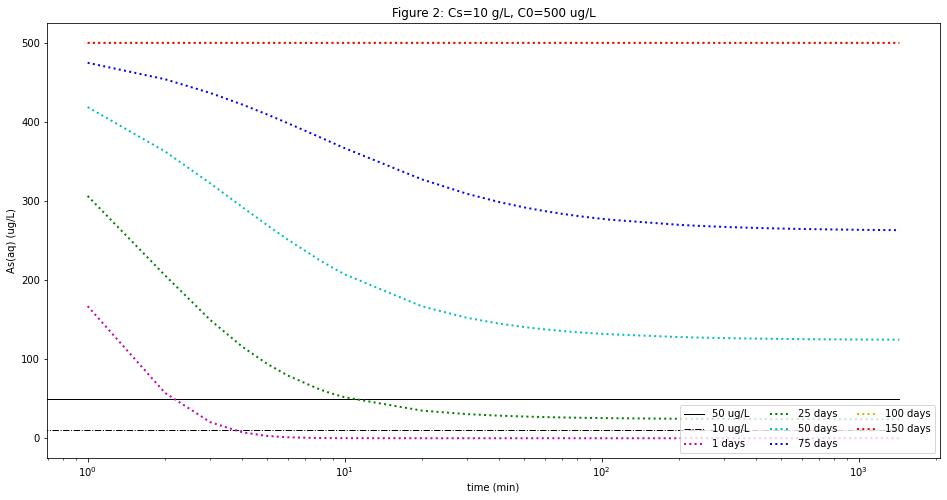

In [ ]:
fig, ax = plt.subplots(1, 1,figsize=(16, 8))


ax.plot(data_collect1, [50]*len(data_collect1), color='k', linestyle='-', linewidth=1,
           )

ax.plot(data_collect1, [10]*len(data_collect1), color='k', linestyle='-.', linewidth=1,
           )


ax.plot(data_collect1[1:], results_Ct_1_5[4][1:], color='m', linestyle=':', linewidth=2
        
        )
ax.plot(data_collect1[1:], results_Ct_25_5[4][1:], color='g', linestyle=':', linewidth=2
       
        )
ax.plot(data_collect1[1:], results_Ct_50_5[4][1:], color='c', linestyle=':', linewidth=2
      
       )

ax.plot(data_collect1[1:], results_Ct_75_5[4][1:], color='b', linestyle=':', linewidth=2
       
       )

ax.plot(data_collect1[1:], results_Ct_100_5[3][1:], color='y', linestyle=':', linewidth=2
      
       )

ax.plot(data_collect1[1:], results_Ct_150_5[3][1:], color='r', linestyle=':', linewidth=2
      
       )

ax.set_title('Figure 2: Cs=10 g/L, C0=500 ug/L')
ax.legend(labels=['50 ug/L','10 ug/L','1 days',"25 days","50 days","75 days","100 days","150 days"], ncol=3,loc="lower right")
ax.set_xscale('log')
ax.set_ylabel('As(aq) (ug/L)')
ax.set_xlabel('time (min)')
plt.show()

### 2.1.2 Section 2: Cs=10 g/L, C0=2000 ug/L
This section compares the changes in the concentration of arsenic in solution as the number of reaction days increases for a rate constant equal to 0.111, adsorption capacity equivalent to 5.1, arsenic concentration in the resolution of 2000, and an initial adsorbent concentration of 10

In [ ]:

results_Ct_5_2,_,data_collect2,_=Result_Processing (2000,10,5)


results_Ct_10_2,_,data_collect2,_=Result_Processing (2000,10,10)


results_Ct_25_2,_,data_collect2,_=Result_Processing (2000,10,25)


results_Ct_30_2,_,data_collect2,_=Result_Processing (2000,10,30)


results_Ct_45_2,_,data_collect2,_=Result_Processing (2000,10,45)


results_Ct_60_2,_,data_collect2,_=Result_Processing (2000,10,60)


#### 2.1.2.1 Plot the results

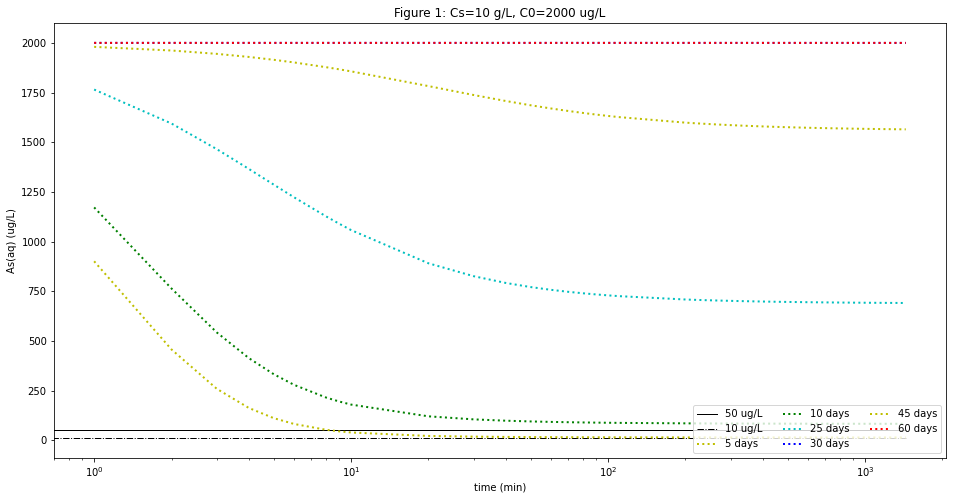

In [ ]:
fig, ax = plt.subplots(1, 1,figsize=(16, 8))



ax.plot(data_collect2, [50]*(len(data_collect2)), color='k', linestyle='-', linewidth=1,
           )

ax.plot(data_collect2, [10]*(len(data_collect2)), color='k', linestyle='-.', linewidth=1,
           )


ax.plot(data_collect2[1:], results_Ct_5_2[4][1:], color='y', linestyle=':', linewidth=2
        
        )
ax.plot(data_collect2[1:], results_Ct_10_2[4][1:], color='g', linestyle=':', linewidth=2
       
        )
ax.plot(data_collect2[1:], results_Ct_25_2[4][1:], color='c', linestyle=':', linewidth=2
      
       )

ax.plot(data_collect2[1:], results_Ct_30_2[3][1:], color='b', linestyle=':', linewidth=2
       
       )

ax.plot(data_collect2[1:], results_Ct_45_2[4][1:], color='y', linestyle=':', linewidth=2
      
       )

ax.plot(data_collect2[1:], results_Ct_60_2[3][1:], color='r', linestyle=':', linewidth=2
      
       )

ax.set_title('Figure 1: Cs=10 g/L, C0=2000 ug/L')
ax.set_xscale('log')
ax.legend(labels=['50 ug/L','10 ug/L','5 days',"10 days","25 days","30 days","45 days","60 days"], ncol=3,loc="lower right")
ax.set_ylabel('As(aq) (ug/L)')
ax.set_xlabel('time (min)')
plt.show()

### 2.1.3 Section 3: Cs=100 g/L, C0=500 ug/L
This section compares the changes in the concentration of arsenic in solution as the number of reaction days increases for a rate constant equal to 0.111, adsorption capacity equivalent to 5.1, arsenic concentration in the resolution of 500, and an initial adsorbent concentration of 100

In [ ]:

results_Ct_100_5,_,data_collect3,_=Result_Processing (500,100,100)


results_Ct_150_5,_,data_collect3,_=Result_Processing (500,100,150)


results_Ct_200_5,_,data_collect3,_=Result_Processing (500,100,200)


results_Ct_250_5,_,data_collect3,_=Result_Processing (500,100,250)


results_Ct_300_5,_,data_collect3,_=Result_Processing (500,100,300)


results_Ct_365_5,_,data_collect3,results_table=Result_Processing (500,100,365)

#### 2.1.3.1 Plot the results

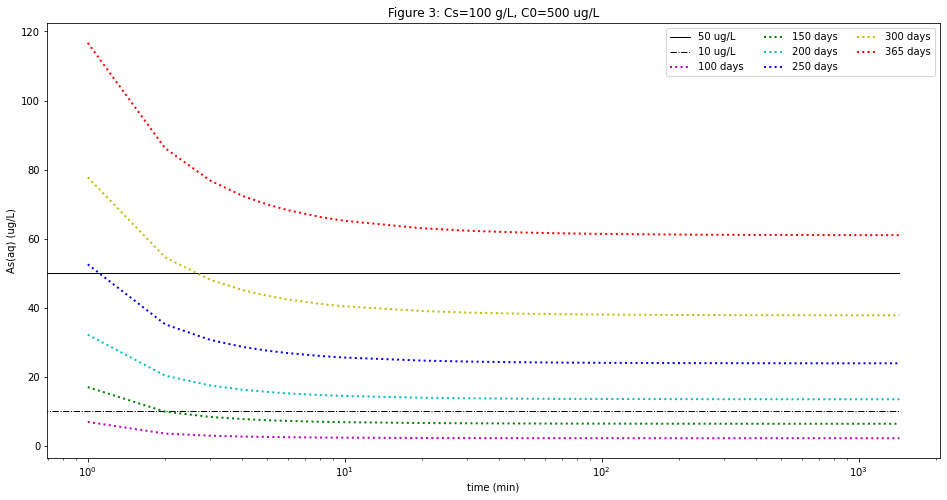

In [ ]:
fig, ax = plt.subplots(1, 1,figsize=(16, 8))

ax.plot(data_collect3, [50]*len(data_collect3), color='k', linestyle='-', linewidth=1,
           )

ax.plot(data_collect3, [10]*len(data_collect3), color='k', linestyle='-.', linewidth=1,
           )


ax.plot(data_collect3[1:], results_Ct_100_5[4][1:], color='m', linestyle=':', linewidth=2
        
        )
ax.plot(data_collect3[1:], results_Ct_150_5[4][1:], color='g', linestyle=':', linewidth=2
       
        )
ax.plot(data_collect3[1:], results_Ct_200_5[4][1:], color='c', linestyle=':', linewidth=2
      
       )

ax.plot(data_collect3[1:], results_Ct_250_5[4][1:], color='b', linestyle=':', linewidth=2
       
       )

ax.plot(data_collect3[1:], results_Ct_300_5[4][1:], color='y', linestyle=':', linewidth=2
      
       )

ax.plot(data_collect3[1:], results_Ct_365_5[4][1:], color='r', linestyle=':', linewidth=2
      
       )
ax.set_title('Figure 3: Cs=100 g/L, C0=500 ug/L')
ax.legend(labels=['50 ug/L','10 ug/L','100 days',"150 days","200 days","250 days","300 days","365 days"], ncol=3,loc="upper right")
ax.set_xscale('log')
ax.set_ylabel('As(aq) (ug/L)')
ax.set_xlabel('time (min)')
plt.show()

### 2.1.4 Section 4: Cs=100 g/L, C0=2000 ug/L
This section compares the changes in the concentration of arsenic in solution as the number of reaction days increases for a rate constant equal to 0.111, adsorption capacity equivalent to 5.1, arsenic concentration in the resolution of 2000, and an initial adsorbent concentration of 100

In [ ]:

results_Ct_30_2,_,data_collect4,_=Result_Processing (2000,100,30)


results_Ct_40_2,_,data_collect4,_=Result_Processing (2000,100,40)


results_Ct_50_2,_,data_collect4,_=Result_Processing (2000,100,50)


results_Ct_60_2,_,data_collect4,_=Result_Processing (2000,100,60)


results_Ct_70_2,_,data_collect4,_=Result_Processing (2000,100,70)

results_Ct_80_2,_,data_collect4,_=Result_Processing (2000,100,80)

#### 2.1.4.1 Plot the results

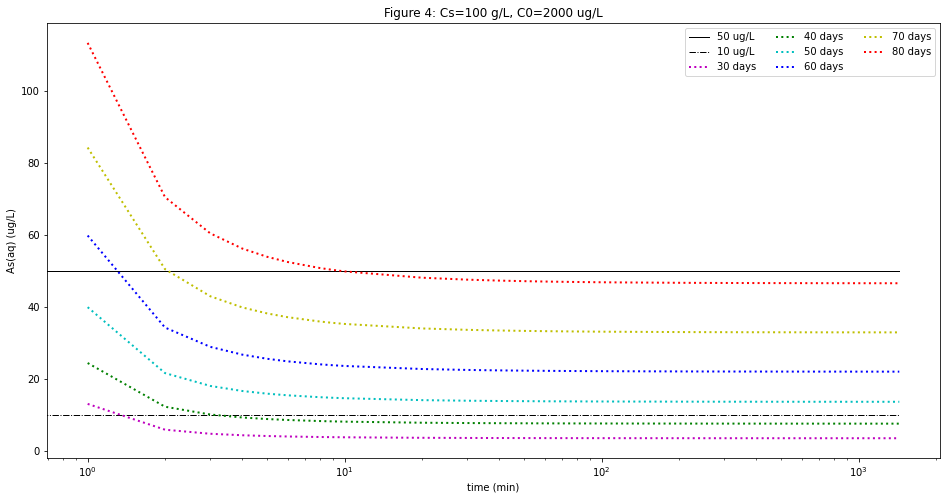

In [ ]:
fig, ax = plt.subplots(1, 1,figsize=(16, 8))
ax.plot(data_collect4, [50]*len(data_collect4), color='k', linestyle='-', linewidth=1,
           )

ax.plot(data_collect4, [10]*len(data_collect4), color='k', linestyle='-.', linewidth=1,
           )


ax.plot(data_collect4[1:], results_Ct_30_2[4][1:], color='m', linestyle=':', linewidth=2
        
        )
ax.plot(data_collect4[1:], results_Ct_40_2[4][1:], color='g', linestyle=':', linewidth=2
       
        )
ax.plot(data_collect4[1:], results_Ct_50_2[4][1:], color='c', linestyle=':', linewidth=2
      
       )

ax.plot(data_collect4[1:], results_Ct_60_2[4][1:], color='b', linestyle=':', linewidth=2
       
       )

ax.plot(data_collect4[1:], results_Ct_70_2[4][1:], color='y', linestyle=':', linewidth=2
      
       )

ax.plot(data_collect4[1:], results_Ct_80_2[4][1:], color='r', linestyle=':', linewidth=2
      
       )
ax.set_title('Figure 4: Cs=100 g/L, C0=2000 ug/L')
ax.legend(labels=['50 ug/L','10 ug/L','30 days',"40 days","50 days","60 days","70 days","80 days"], ncol=3,loc="upper right")
ax.set_xscale('log')
ax.set_ylabel('As(aq) (ug/L)')
ax.set_xlabel('time (min)')
plt.show()


### 2.1.5 Visualising the comparison results

The Figures 1 to 4 correspond to sections 1 to 4.

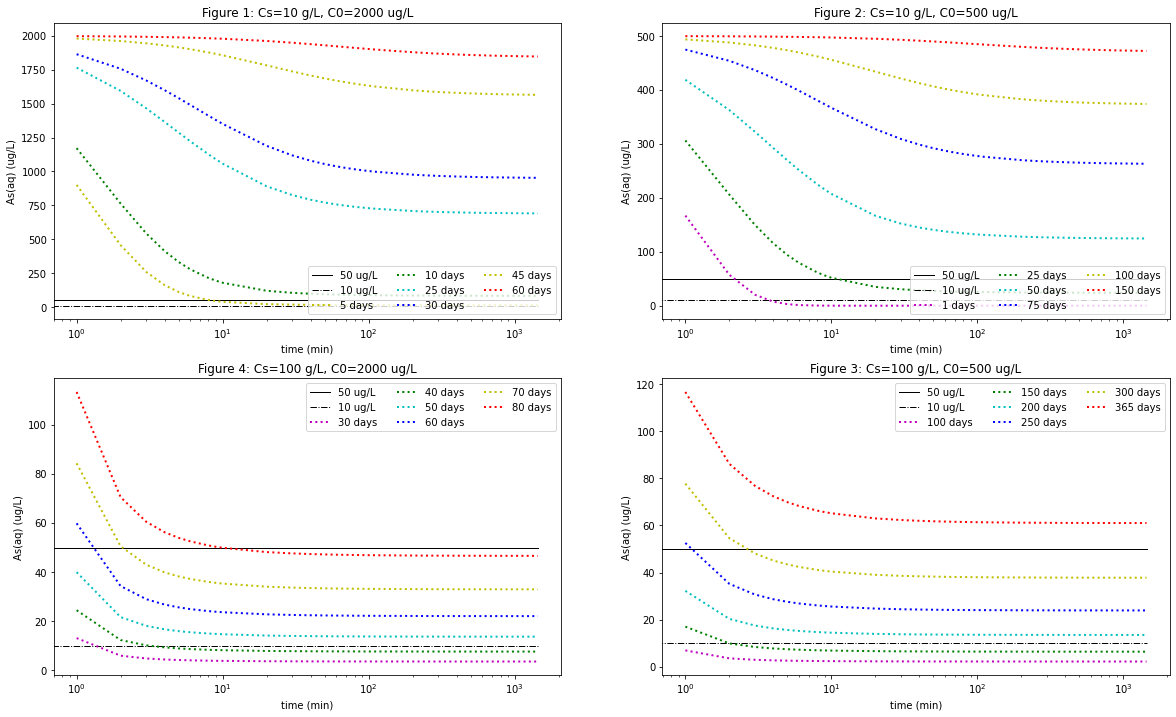

In [ ]:
fig, ax = plt.subplots(2, 2,figsize=(20, 12))

#Cs=10, C0=2000

ax[0, 0].plot(data_collect2, [50]*(len(data_collect2)), color='k', linestyle='-', linewidth=1,
           )

ax[0, 0].plot(data_collect2, [10]*(len(data_collect2)), color='k', linestyle='-.', linewidth=1,
           )


ax[0, 0].plot(data_collect2[1:], results_Ct_5_2[4][1:], color='y', linestyle=':', linewidth=2
        
        )
ax[0, 0].plot(data_collect2[1:], results_Ct_10_2[4][1:], color='g', linestyle=':', linewidth=2
       
        )
ax[0, 0].plot(data_collect2[1:], results_Ct_25_2[4][1:], color='c', linestyle=':', linewidth=2
      
       )

ax[0, 0].plot(data_collect2[1:], results_Ct_30_2[3][1:], color='b', linestyle=':', linewidth=2
       
       )

ax[0, 0].plot(data_collect2[1:], results_Ct_45_2[4][1:], color='y', linestyle=':', linewidth=2
      
       )

ax[0, 0].plot(data_collect2[1:], results_Ct_60_2[3][1:], color='r', linestyle=':', linewidth=2
      
       )

ax[0, 0].set_title('Figure 1: Cs=10 g/L, C0=2000 ug/L')
ax[0, 0].set_xscale('log')
ax[0, 0].legend(labels=['50 ug/L','10 ug/L','5 days',"10 days","25 days","30 days","45 days","60 days"], ncol=3,loc="lower right")
ax[0, 0].set_ylabel('As(aq) (ug/L)')
ax[0, 0].set_xlabel('time (min)')

#Cs=10, C0=500
###########################################

ax[0, 1].plot(data_collect1, [50]*len(data_collect1), color='k', linestyle='-', linewidth=1,
           )

ax[0, 1].plot(data_collect1, [10]*len(data_collect1), color='k', linestyle='-.', linewidth=1,
           )


ax[0, 1].plot(data_collect1[1:], results_Ct_1_5[4][1:], color='m', linestyle=':', linewidth=2
        
        )
ax[0, 1].plot(data_collect1[1:], results_Ct_25_5[4][1:], color='g', linestyle=':', linewidth=2
       
        )
ax[0, 1].plot(data_collect1[1:], results_Ct_50_5[4][1:], color='c', linestyle=':', linewidth=2
      
       )

ax[0, 1].plot(data_collect1[1:], results_Ct_75_5[4][1:], color='b', linestyle=':', linewidth=2
       
       )

ax[0, 1].plot(data_collect1[1:], results_Ct_100_5[3][1:], color='y', linestyle=':', linewidth=2
      
       )

ax[0, 1].plot(data_collect1[1:], results_Ct_150_5[3][1:], color='r', linestyle=':', linewidth=2
      
       )

ax[0, 1].set_title('Figure 2: Cs=10 g/L, C0=500 ug/L')
ax[0, 1].legend(labels=['50 ug/L','10 ug/L','1 days',"25 days","50 days","75 days","100 days","150 days"], ncol=3,loc="lower right")
ax[0, 1].set_xscale('log')
ax[0, 1].set_ylabel('As(aq) (ug/L)')
ax[0, 1].set_xlabel('time (min)')

#Cs=100, C0=500
###########################################

ax[1, 1].plot(data_collect3, [50]*len(data_collect3), color='k', linestyle='-', linewidth=1,
           )

ax[1, 1].plot(data_collect3, [10]*len(data_collect3), color='k', linestyle='-.', linewidth=1,
           )


ax[1, 1].plot(data_collect3[1:], results_Ct_100_5[4][1:], color='m', linestyle=':', linewidth=2
        
        )
ax[1, 1].plot(data_collect3[1:], results_Ct_150_5[4][1:], color='g', linestyle=':', linewidth=2
       
        )
ax[1, 1].plot(data_collect3[1:], results_Ct_200_5[4][1:], color='c', linestyle=':', linewidth=2
      
       )

ax[1, 1].plot(data_collect3[1:], results_Ct_250_5[4][1:], color='b', linestyle=':', linewidth=2
       
       )

ax[1, 1].plot(data_collect3[1:], results_Ct_300_5[4][1:], color='y', linestyle=':', linewidth=2
      
       )

ax[1, 1].plot(data_collect3[1:], results_Ct_365_5[4][1:], color='r', linestyle=':', linewidth=2
      
       )
ax[1, 1].set_title('Figure 3: Cs=100 g/L, C0=500 ug/L')
ax[1, 1].legend(labels=['50 ug/L','10 ug/L','100 days',"150 days","200 days","250 days","300 days","365 days"], ncol=3,loc="upper right")
ax[1, 1].set_xscale('log')
ax[1, 1].set_ylabel('As(aq) (ug/L)')
ax[1, 1].set_xlabel('time (min)')

#Cs=100, C0=2000
###########################################

ax[1, 0].plot(data_collect4, [50]*len(data_collect4), color='k', linestyle='-', linewidth=1,
           )

ax[1, 0].plot(data_collect4, [10]*len(data_collect4), color='k', linestyle='-.', linewidth=1,
           )


ax[1, 0].plot(data_collect4[1:], results_Ct_30_2[4][1:], color='m', linestyle=':', linewidth=2
        
        )
ax[1, 0].plot(data_collect4[1:], results_Ct_40_2[4][1:], color='g', linestyle=':', linewidth=2
       
        )
ax[1, 0].plot(data_collect4[1:], results_Ct_50_2[4][1:], color='c', linestyle=':', linewidth=2
      
       )

ax[1, 0].plot(data_collect4[1:], results_Ct_60_2[4][1:], color='b', linestyle=':', linewidth=2
       
       )

ax[1, 0].plot(data_collect4[1:], results_Ct_70_2[4][1:], color='y', linestyle=':', linewidth=2
      
       )

ax[1, 0].plot(data_collect4[1:], results_Ct_80_2[4][1:], color='r', linestyle=':', linewidth=2
      
       )
ax[1, 0].set_title('Figure 4: Cs=100 g/L, C0=2000 ug/L')
ax[1, 0].legend(labels=['50 ug/L','10 ug/L','30 days',"40 days","50 days","60 days","70 days","80 days"], ncol=3,loc="upper right")
ax[1, 0].set_xscale('log')
ax[1, 0].set_ylabel('As(aq) (ug/L)')
ax[1, 0].set_xlabel('time (min)')
plt.show()

## 2.2 The effect of parameters on the model in the presence of time variation

### 2.2.1 Section 5: Effect of rate constants
Vary the rate constant within the margin of error and observe the effect on the concentration of arsenic in the solution (0.111 +/- 0.015)

In [ ]:
results_Ct_rc_0111,Cs_0111,data_collect_rc,results_table_rc_0111=Result_Processing (500,10,175,k_in=0.111)


results_Ct_rc_0126,Cs_0126,data_collect_rc,results_table_rc_0126=Result_Processing (500,10,175,k_in=0.126)


results_Ct_rc_0096,Cs_0096,data_collect_rc,results_table_rc_0096=Result_Processing (500,10,175,k_in=0.096)



#### 2.2.1.1 Plot the results

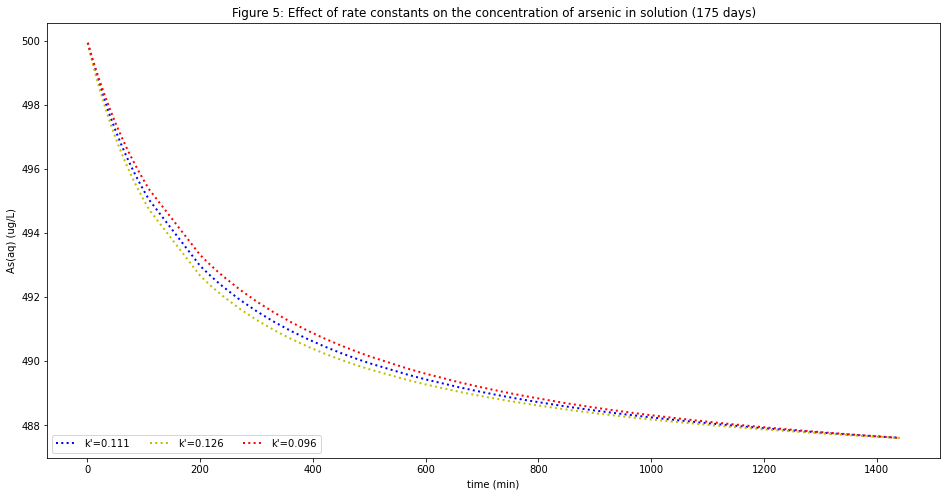

In [ ]:
fig, ax = plt.subplots(1, 1,figsize=(16, 8))

#Cs=10, C0=500 k'= 0.111 +/- 0.015

ax.plot(data_collect_rc[1:], results_Ct_rc_0111[4][1:], color='b', linestyle=':', linewidth=2
       
       )

ax.plot(data_collect_rc[1:], results_Ct_rc_0126[4][1:], color='y', linestyle=':', linewidth=2
      
       )

ax.plot(data_collect_rc[1:], results_Ct_rc_0096[4][1:], color='r', linestyle=':', linewidth=2
      
       )

ax.set_title('Figure 5: Effect of rate constants on the concentration of arsenic in solution (175 days)')
ax.legend(labels=["k'=0.111","k'=0.126","k'=0.096"], ncol=3,loc="lower left")
ax.set_ylabel('As(aq) (ug/L)')
ax.set_xlabel('time (min)')
plt.show()

### 2.2.2 Section 6: Effect of Freundlich parameters
Vary the Freundlich parameters within the margin of error and observe the effect on the concentration of arsenic in the solution (5.10 +/- 0.160)

In [ ]:
results_Ct_F_510,Cs_510,data_collect_F,results_table_F_510=Result_Processing (500,10,175,KF_in=5.10)


results_Ct_F_494,Cs_494,data_collect_F,results_table_F_494=Result_Processing (500,10,175,KF_in=4.94)


results_Ct_F_526,Cs_526,data_collect_F,results_table_F_526=Result_Processing (500,10,175,KF_in=5.26)




#### 2.2.2.1 Plot the results

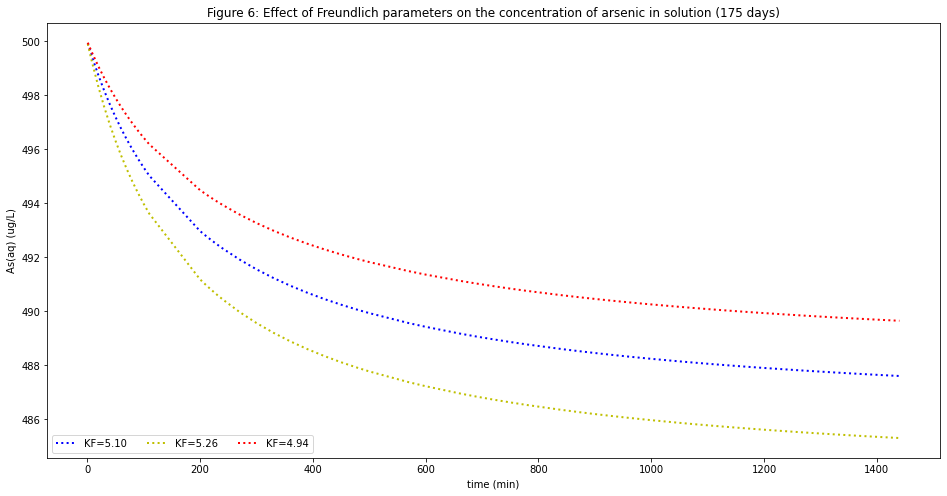

In [ ]:
fig, ax = plt.subplots(1, 1,figsize=(16, 8))
ax.plot(data_collect_F[1:], results_Ct_F_510[4][1:], color='b', linestyle=':', linewidth=2
       
       )

ax.plot(data_collect_F[1:], results_Ct_F_526[4][1:], color='y', linestyle=':', linewidth=2
      
       )

ax.plot(data_collect_F[1:], results_Ct_F_494[4][1:], color='r', linestyle=':', linewidth=2
      
       )

ax.set_title('Figure 6: Effect of Freundlich parameters on the concentration of arsenic in solution (175 days)')
ax.legend(labels=["KF=5.10","KF=5.26","KF=4.94"], ncol=3,loc="lower left")
ax.set_ylabel('As(aq) (ug/L)')
ax.set_xlabel('time (min)')


plt.show()

### 2.2.3 Section 7: Effect of parameters n
Vary the parameter n within the margin of error and observe the effect on the concentration of arsenic in the solution (2.63 +/- 0.14)

In [ ]:
results_Ct_n_249,Cs_249,data_collect_n,results_table_n_249=Result_Processing (500,10,175,n_in=2.49)


results_Ct_n_263,CS_263,data_collect2_n,results_table_n_263=Result_Processing (500,10,175,n_in=2.63)


results_Ct_n_277,Cs_277,data_collect2_n,results_table_n_277=Result_Processing (500,10,175,n_in=2.77)




#### 2.2.3.1 Plot the results

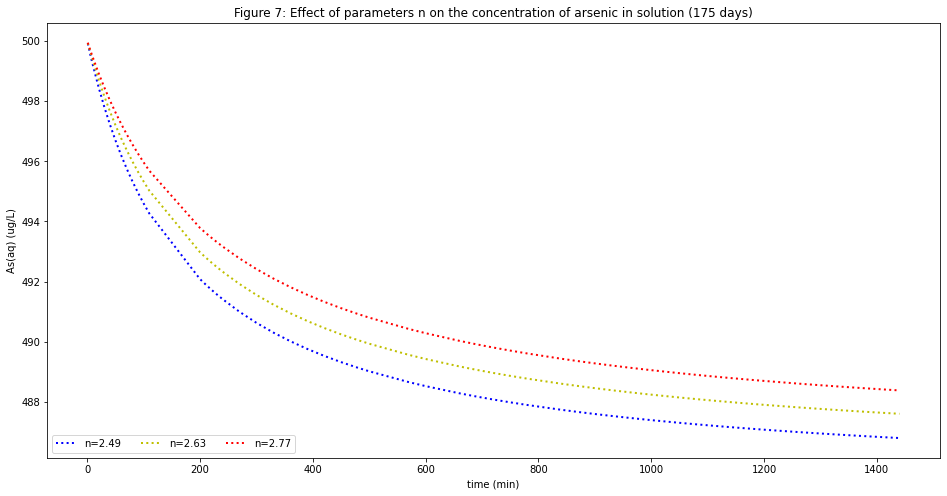

In [ ]:
fig, ax = plt.subplots(1, 1,figsize=(16, 8))
ax.plot(data_collect_n[1:], results_Ct_n_249[4][1:], color='b', linestyle=':', linewidth=2
       
       )

ax.plot(data_collect_n[1:], results_Ct_n_263[4][1:], color='y', linestyle=':', linewidth=2
      
       )

ax.plot(data_collect_n[1:], results_Ct_n_277[4][1:], color='r', linestyle=':', linewidth=2
      
       )

ax.set_title('Figure 7: Effect of parameters n on the concentration of arsenic in solution (175 days)')
ax.legend(labels=["n=2.49","n=2.63","n=2.77"], ncol=3,loc="lower left")
ax.set_ylabel('As(aq) (ug/L)')
ax.set_xlabel('time (min)')
plt.show()

### 2.2.4  Visualising the comparison results 

The Figures 5 to 7 correspond to sections 5 to 7.

Text(0.5, 0, 'time (min)')

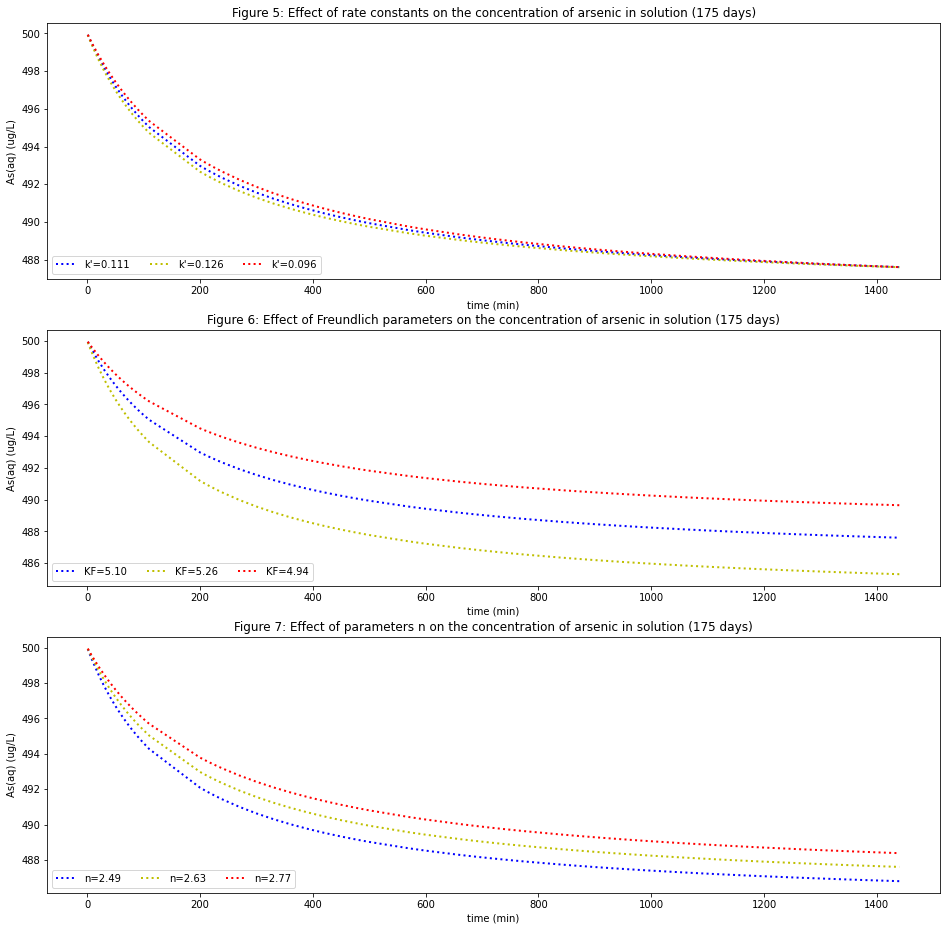

In [ ]:
fig, ax = plt.subplots(3, 1,figsize=(16, 16))

#Cs=10, C0=500 k'= 0.111 +/- 0.015

ax[0].plot(data_collect_rc[1:], results_Ct_rc_0111[4][1:], color='b', linestyle=':', linewidth=2
       
       )

ax[0].plot(data_collect_rc[1:], results_Ct_rc_0126[4][1:], color='y', linestyle=':', linewidth=2
      
       )

ax[0].plot(data_collect_rc[1:], results_Ct_rc_0096[4][1:], color='r', linestyle=':', linewidth=2
      
       )

ax[0].set_title('Figure 5: Effect of rate constants on the concentration of arsenic in solution (175 days)')
ax[0].legend(labels=["k'=0.111","k'=0.126","k'=0.096"], ncol=3,loc="lower left")
ax[0].set_ylabel('As(aq) (ug/L)')
ax[0].set_xlabel('time (min)')
#Cs=10, C0=500 kf= 5.10 +/- 1.60

ax[1].plot(data_collect_F[1:], results_Ct_F_510[4][1:], color='b', linestyle=':', linewidth=2
       
       )

ax[1].plot(data_collect_F[1:], results_Ct_F_526[4][1:], color='y', linestyle=':', linewidth=2
      
       )

ax[1].plot(data_collect_F[1:], results_Ct_F_494[4][1:], color='r', linestyle=':', linewidth=2
      
       )

ax[1].set_title('Figure 6: Effect of Freundlich parameters on the concentration of arsenic in solution (175 days)')
ax[1].legend(labels=["KF=5.10","KF=5.26","KF=4.94"], ncol=3,loc="lower left")
ax[1].set_ylabel('As(aq) (ug/L)')
ax[1].set_xlabel('time (min)')




#Cs=10, C0=500 n = 2.63 +/- 0.14

ax[2].plot(data_collect_n[1:], results_Ct_n_249[4][1:], color='b', linestyle=':', linewidth=2
       
       )

ax[2].plot(data_collect_n[1:], results_Ct_n_263[4][1:], color='y', linestyle=':', linewidth=2
      
       )

ax[2].plot(data_collect_n[1:], results_Ct_n_277[4][1:], color='r', linestyle=':', linewidth=2
      
       )

ax[2].set_title('Figure 7: Effect of parameters n on the concentration of arsenic in solution (175 days)')
ax[2].legend(labels=["n=2.49","n=2.63","n=2.77"], ncol=3,loc="lower left")
ax[2].set_ylabel('As(aq) (ug/L)')
ax[2].set_xlabel('time (min)')



## 2.3 Adsorbents required to treatment

### 2.3.1 Section 8: Different Concentrations of Arsenic
Number of adsorbents required to treat solutions with different concentrations of arsenic

In [ ]:
_,Cs_500,_,results_table_500=Result_Processing (500,100,365)
_,Cs_1000,_,results_table_1000=Result_Processing (1000,100,365)
_,Cs_2000,_,results_table_2000=Result_Processing (2000,100,365)
_,Cs_3000,_,results_table_3000=Result_Processing (3000,100,365)

In [ ]:
result=[Min_adsorbent(results_table_500[-1],Cs_500),Min_adsorbent(results_table_1000[-1],Cs_1000),
        Min_adsorbent(results_table_2000[-1],Cs_2000),Min_adsorbent(results_table_3000[-1],Cs_3000)]

#### 2.3.1.1 Plot the results

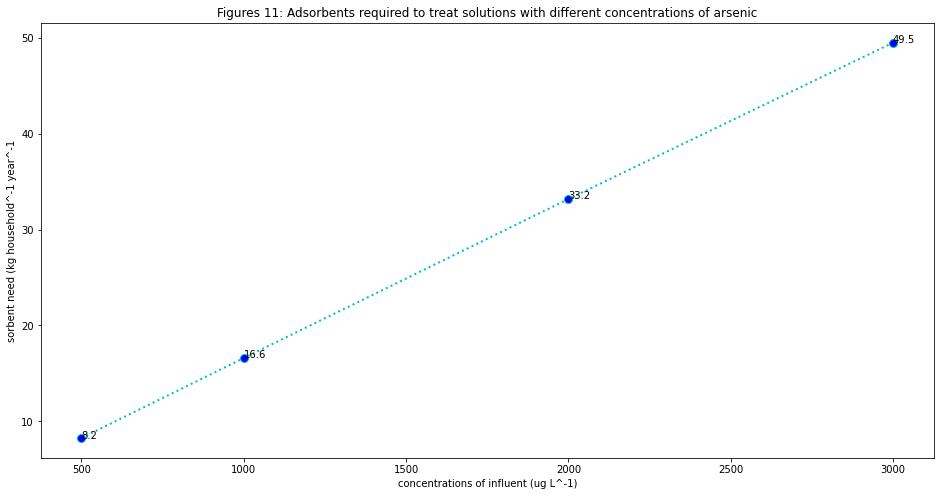

In [ ]:
fig, ax = plt.subplots(1, 1,figsize=(16, 8))
C0_con=[500,1000,2000,3000]
ax.plot(C0_con, result, color='c', linestyle=':', linewidth=2,marker='o',
         markerfacecolor='blue', markersize=8 )
for a, b in zip(C0_con, result):
    ax.text(round(a,1), round(b,1), round(b,1), fontsize=10)

ax.set_title('Figures 11: Adsorbents required to treat solutions with different concentrations of arsenic')
ax.set_xlabel('concentrations of influent (ug L^-1)')
ax.set_ylabel('sorbent need (kg household^-1 year^-1')

plt.show()

### 2.3.2 Section 9: Effect of rate constants on adsorbent

All other conditions being equal, vary the value of the rate constant and analyse the effect of the rate constant on the amount of adsorbent used

In [ ]:
result_rc=[Min_adsorbent(results_table_rc_0096[-1],Cs_0096),Min_adsorbent(results_table_rc_0111[-1],Cs_0111),
           Min_adsorbent(results_table_rc_0126[-1],Cs_0126)]

#### 2.3.2.1 Plot the results

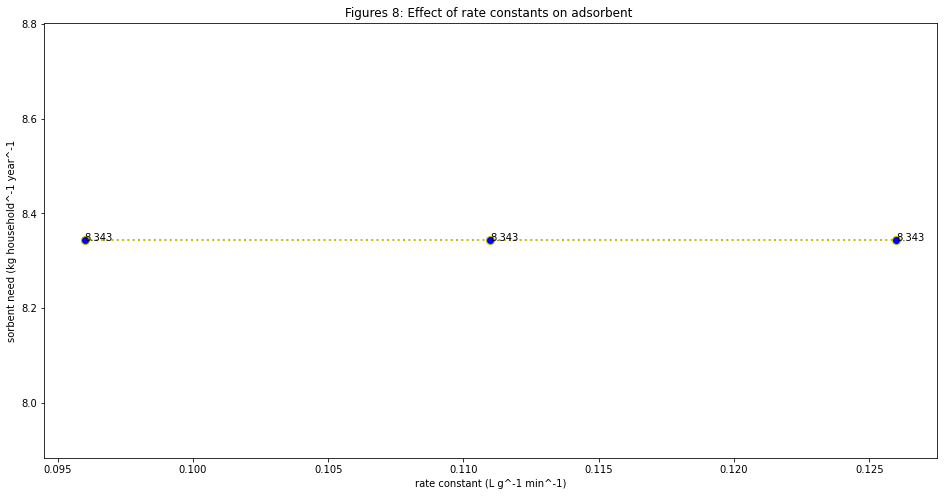

In [ ]:
fig, ax = plt.subplots(1, 1,figsize=(16, 8))
k=[0.096,0.111,0.126]

ax.plot(k, result_rc, color='y', linestyle=':', linewidth=2, marker='o',
         markerfacecolor='blue', markersize=8 )

for a, b in zip(k, result_rc):
    ax.text(round(a,3), round(b,3), round(b,3), fontsize=10)


ax.set_title('Figures 8: Effect of rate constants on adsorbent ')
ax.set_xlabel('rate constant (L g^-1 min^-1)')
ax.set_ylabel('sorbent need (kg household^-1 year^-1')

plt.show()

### 2.3.3 Section 10: Effect of Freundlich parameters on adsorbent
All other conditions being equal, vary the value of the Freundlich parameters and analyse the effect of the rate constant on the amount of adsorbent used

In [ ]:
result_F=[Min_adsorbent(results_table_F_494[-1],Cs_494),Min_adsorbent(results_table_F_510[-1],Cs_510),
          Min_adsorbent(results_table_F_526[-1],Cs_526)]

#### 2.3.3.1 Plot the results

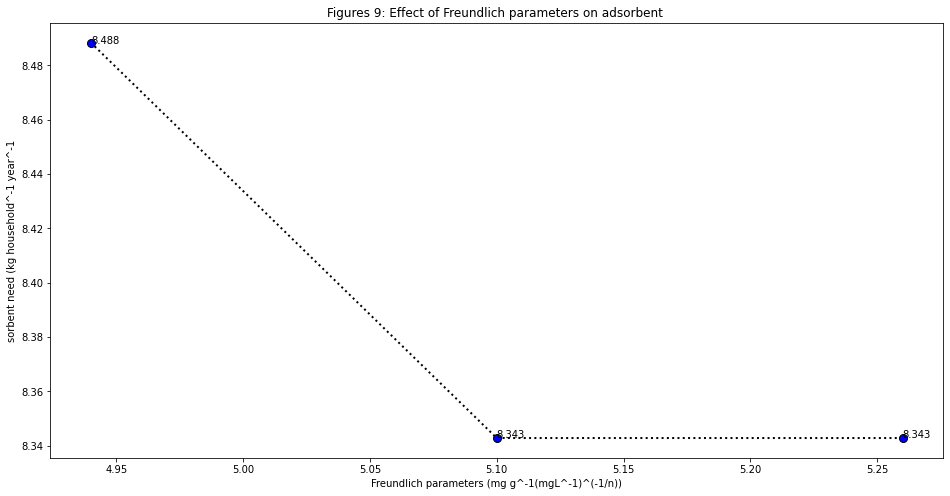

In [ ]:
fig, ax = plt.subplots(1, 1,figsize=(16, 8))
KF=[4.94,5.10,5.26]

ax.plot(KF, result_F, color='k', linestyle=':', linewidth=2, marker='o',
         markerfacecolor='blue', markersize=8)

for a, b in zip(KF, result_F):
    ax.text(round(a,3), round(b,3), round(b,3), fontsize=10)

ax.set_title('Figures 9: Effect of Freundlich parameters on adsorbent ')
ax.set_xlabel('Freundlich parameters (mg g^-1(mgL^-1)^(-1/n))')
ax.set_ylabel('sorbent need (kg household^-1 year^-1')


plt.show()

### 2.3.4 Section 11: Effect of n on adsorbent
All other conditions being equal, vary the value of the parameters n and analyse the effect of the rate constant on the amount of adsorbent used

In [ ]:
result_n=[Min_adsorbent(results_table_n_249[-1],Cs_249),Min_adsorbent(results_table_n_263[-1],CS_263),
          Min_adsorbent(results_table_n_277[-1],Cs_277)]

#### 2.3.4.1 Plot the results

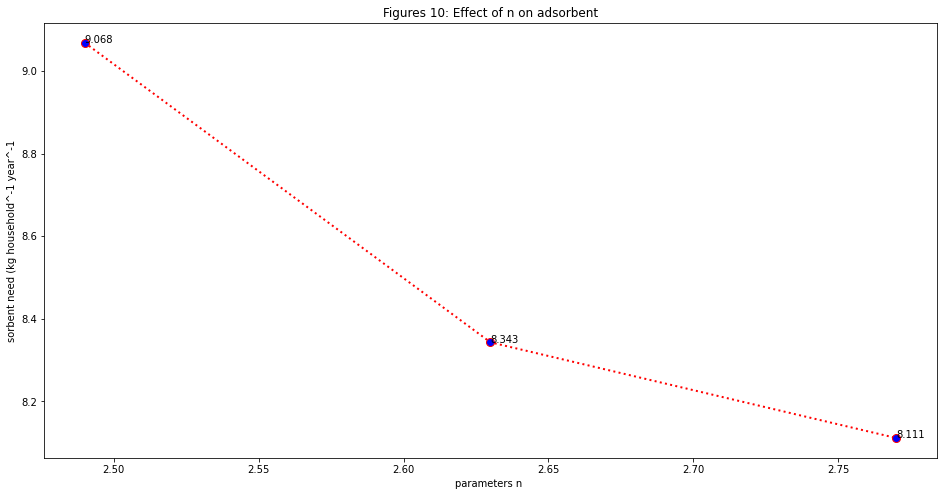

In [ ]:
fig, ax = plt.subplots(1, 1,figsize=(16, 8))
n=[2.49,2.63,2.77]

ax.plot(n, result_n, color='r', linestyle=':', linewidth=2, marker='o',
         markerfacecolor='blue', markersize=8)
for i, j in zip(n, result_n):
    ax.text(round(i,3), round(j,3), round(j,3),  fontsize=10)

ax.set_title('Figures 10: Effect of n on adsorbent')
ax.set_xlabel('parameters n ')
ax.set_ylabel('sorbent need (kg household^-1 year^-1')


plt.show()

### 2.3.5 Visualising the comparison results

The Figures 8 to 11 correspond to sections 8 to 11

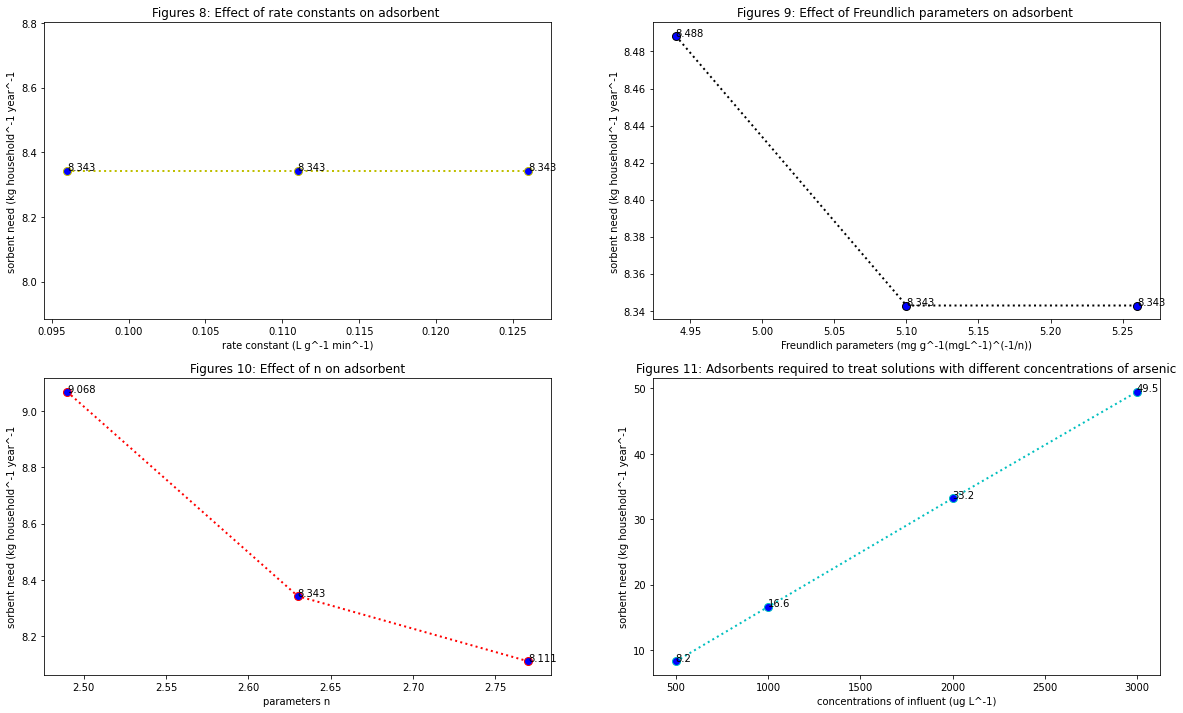

In [ ]:
fig, ax = plt.subplots(2, 2,figsize=(20, 12))

# rate constant(k')=[0.096,0.111,0.126]
###########################################
k=[0.096,0.111,0.126]

ax[0, 0].plot(k, result_rc, color='y', linestyle=':', linewidth=2, marker='o',
         markerfacecolor='blue', markersize=8 )

for a, b in zip(k, result_rc):
    ax[0, 0].text(round(a,3), round(b,3), round(b,3), fontsize=10)


ax[0, 0].set_title('Figures 8: Effect of rate constants on adsorbent ')
ax[0,0].set_xlabel('rate constant (L g^-1 min^-1)')
ax[0,0].set_ylabel('sorbent need (kg household^-1 year^-1')

# Freundlich parameters(KF)=[4.94,5.10,5.26]
###########################################
KF=[4.94,5.10,5.26]

ax[0, 1].plot(KF, result_F, color='k', linestyle=':', linewidth=2, marker='o',
         markerfacecolor='blue', markersize=8)

for a, b in zip(KF, result_F):
    ax[0, 1].text(round(a,3), round(b,3), round(b,3), fontsize=10)

ax[0, 1].set_title('Figures 9: Effect of Freundlich parameters on adsorbent ')
ax[0,1].set_xlabel('Freundlich parameters (mg g^-1(mgL^-1)^(-1/n))')
ax[0,1].set_ylabel('sorbent need (kg household^-1 year^-1')


# n=[2.49,2.63,2.77]
###########################################

n=[2.49,2.63,2.77]

ax[1, 0].plot(n, result_n, color='r', linestyle=':', linewidth=2, marker='o',
         markerfacecolor='blue', markersize=8)
for i, j in zip(n, result_n):
    ax[1, 0].text(round(i,3), round(j,3), round(j,3),  fontsize=10)

ax[1, 0].set_title('Figures 10: Effect of n on adsorbent')
ax[1,0].set_xlabel('parameters n ')
ax[1,0].set_ylabel('sorbent need (kg household^-1 year^-1')


# days=365 Cs=[1,10,100,1000,10000] C0=[500,1000,2000,3000]
###########################################

C0_con=[500,1000,2000,3000]
ax[1, 1].plot(C0_con, result, color='c', linestyle=':', linewidth=2,marker='o',
         markerfacecolor='blue', markersize=8 )
for a, b in zip(C0_con, result):
    ax[1, 1].text(round(a,1), round(b,1), round(b,1), fontsize=10)

ax[1, 1].set_title('Figures 11: Adsorbents required to treat solutions with different concentrations of arsenic')
ax[1,1].set_xlabel('concentrations of influent (ug L^-1)')
ax[1,1].set_ylabel('sorbent need (kg household^-1 year^-1')

plt.show()

## 2.4 Effect of different models with the same parameters on the results

### 2.4.1 Section 12: Kinetic Energy Adsorption Equation
Compare the first order Langmuir kinetic energy adsorption equation, compare the second order Langmuir kinetic energy adsorption equation, the first order Freundlich kinetic energy adsorption equation, and the second order Freundlich kinetic energy adsorption equation under the same conditions

In [ ]:
#test
results_Ct_1_Lan,_,data_collect_1_Lan,results_table_1_Lan=Result_Processing (500,10,1,ord_in=1,isotherms="Langmuir")
results_Ct_2_Lan,_,data_collect_2_Lan,results_table_2_Lan=Result_Processing (500,10,1,ord_in=2,isotherms="Langmuir")
results_Ct_1_Fre,_,data_collect_1_Fre,results_table_1_Fre=Result_Processing (500,10,1,ord_in=1)
results_Ct_2_Fre,_,data_collect_2_Fre,results_table_2_Fre=Result_Processing (500,10,1)

#### 2.4.1.1 Plotting the results of section 12

Text(0.5, 0, 'time (min)')

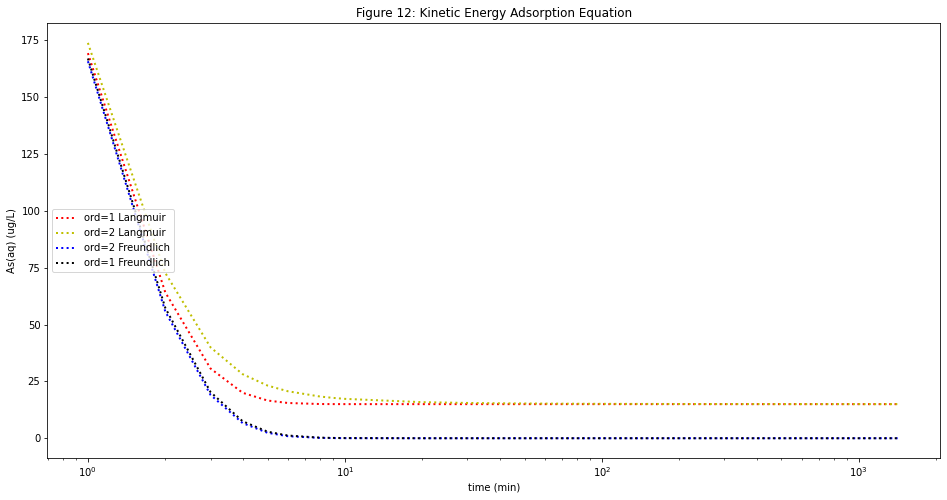

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))



ax.plot(data_collect_1_Lan[1:], results_Ct_1_Lan[4][1:], color='r', linestyle=':', linewidth=2,
        
        )
ax.plot(data_collect_2_Lan[1:], results_Ct_2_Lan[4][1:], color='y', linestyle=':', linewidth=2,
        
        )
ax.plot(data_collect_1_Fre[1:], results_Ct_1_Fre[4][1:], color='b', linestyle=':', linewidth=2,
        
        )
ax.plot(data_collect_2_Fre[1:], results_Ct_2_Fre[4][1:], color='k', linestyle=':', linewidth=2,
        
        )

ax.get_xaxis().get_major_formatter().set_scientific(False)
ax.set_title('Figure 12: Kinetic Energy Adsorption Equation')
ax.legend(labels=['ord=1 Langmuir','ord=2 Langmuir','ord=2 Freundlich',"ord=1 Freundlich"], loc="center left")
ax.set_xscale('log')
ax.set_ylabel('As(aq) (ug/L)')
ax.set_xlabel('time (min)')

### 2.4.2 Section 13: Effect of Kinetic Energy Adsorption Equation
Vary the value of the Kinetic Energy Adsorption Equation and analyse the effect of the rate constant on the amount of adsorbent used

In [ ]:


_,Cs_1_Lan,_,results_table_1_Lan=Result_Processing (500,100,365,ord_in=1,isotherms="Langmuir")
_,Cs_2_Lan,_,results_table_2_Lan=Result_Processing (500,100,365,ord_in=2,isotherms="Langmuir")
_,Cs_1_Fre,_,results_table_1_Fre=Result_Processing (500,100,365,ord_in=1)
_,Cs_2_Fre,_,results_table_2_Fre=Result_Processing (500,100,365)

result_LF=[Min_adsorbent(results_table_1_Lan[-1],Cs_1_Lan),Min_adsorbent(results_table_2_Lan[-1],Cs_2_Lan),
           Min_adsorbent(results_table_1_Fre[-1],Cs_1_Fre),Min_adsorbent(results_table_2_Fre[-1],Cs_2_Fre)]

#### 2.4.2.1 Plotting the results of section 13

Text(0, 0.5, 'sorbent need (kg household^-1 year^-1')

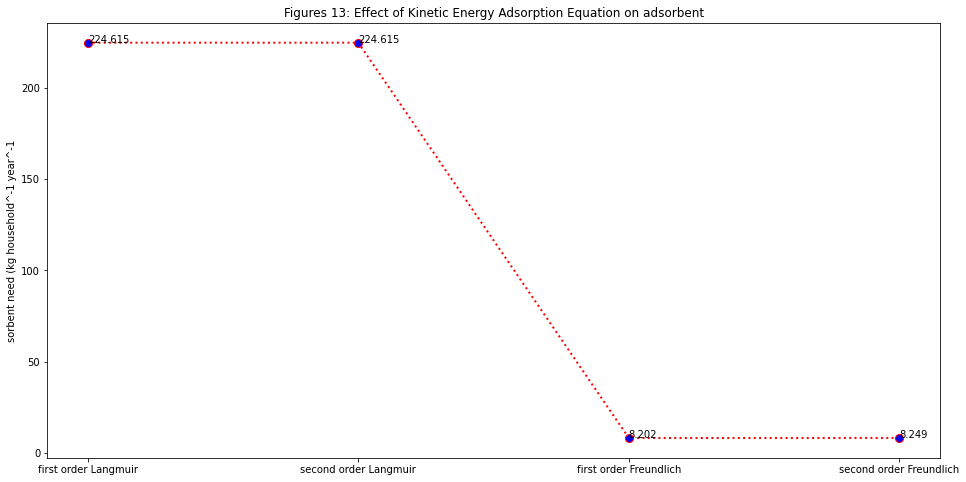

In [ ]:

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

ax.plot(['first order Langmuir','second order Langmuir','first order Freundlich',"second order Freundlich"], result_LF, color='r', linestyle=':', linewidth=2, marker='o',
         markerfacecolor='blue', markersize=8)
for i, j in zip(['first order Langmuir','second order Langmuir','first order Freundlich',"second order Freundlich"], result_LF):
    ax.text(i, round(j,3), round(j,3),  fontsize=10)

ax.set_title('Figures 13: Effect of Kinetic Energy Adsorption Equation on adsorbent')

ax.set_ylabel('sorbent need (kg household^-1 year^-1')